In [226]:
import json
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils.convert import from_networkx
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from codecarbon import track_emissions


In [227]:
json_file = 'elyzee_data/elyzee_train.json'
graph_train_networkx = nx.node_link_graph(json.load(open(json_file)))

json_file = 'elyzee_data/elyzee_test.json'
graph_test_networkx = nx.node_link_graph(json.load(open(json_file)))

In [228]:
num_classes = 7
labels_dict = {
    'lr': 0, 
    'em': 1, 
    'fn': 2, 
    'fi': 3, 
    'ps': 4,
    'multi_affiliations': 5, 
    'indetermined': 6
}
node_id = list(graph_train_networkx.nodes)[0]
num_features = len(graph_train_networkx.nodes[node_id]['features'])

In [229]:
graph_train_torch = from_networkx(graph_train_networkx)
graph_test_torch = from_networkx(graph_test_networkx)
print("Train :",graph_train_torch)
print("Test :",graph_test_torch)

Train : Data(edge_index=[2, 19284], features=[5507, 999], affiliation=[5507], num_nodes=5507)
Test : Data(edge_index=[2, 6402], features=[2222, 999], affiliation=[2222], num_nodes=2222)


In [230]:
graph_train_torch.labels = F.one_hot(torch.tensor(
    [labels_dict[affiliation] for affiliation in graph_train_torch.affiliation]
)).float()
graph_test_torch.labels = F.one_hot(torch.tensor(
    [labels_dict[affiliation] for affiliation in graph_test_torch.affiliation]
)).float()
print("Train labels :", graph_train_torch.labels.shape)
print("Test labels :", graph_test_torch.labels.shape)


Train labels : torch.Size([5507, 7])
Test labels : torch.Size([2222, 7])


# Experience 1 : FCNN

In [231]:
class FCNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(FCNN, self).__init__()
        self.linear1 = nn.Linear(num_features, hidden_channels)
        # self.linear2 = nn.Linear(hidden_channels, hidden_channels)
        # self.linear3 = nn.Linear(hidden_channels, hidden_channels)
        self.out = nn.Linear(hidden_channels, num_classes)

    def forward(self, x):
        x = self.linear1(x)
        x = x.relu()
        x = F.dropout(x, p=0.3, training=self.training)
        
        # x = self.linear2(x)
        # x = x.relu()
        # x = F.dropout(x, p=0.3, training=self.training)
        # 
        # x = self.linear3(x)
        # x = x.relu()
        # x = F.dropout(x, p=0.3, training=self.training)
        
        x = self.out(x)
        x = F.softmax(x, dim=1)
        return x

In [232]:
@track_emissions()
def train(model, graph_train, graph_test, epoches):
    learning_rate = 0.01
    decay = 1e-4
    optimizer = torch.optim.Adam(model.parameters(),
                                     lr=learning_rate,
                                     weight_decay=decay)
    criterion = torch.nn.CrossEntropyLoss()
    
    list_loss_train = []
    list_loss_test = []
    list_train_acc = []
    list_test_acc = []
    for epoch in range(epoches):
        model.train()
        optimizer.zero_grad()
        # Forward
        logits_train = model(graph_train.features)
        # Compute loss
        loss_train = criterion(logits_train, graph_train.labels) 
        list_loss_train.append(loss_train.item())
        # Backward
        loss_train.backward()
        optimizer.step()
        
        train_acc = (torch.argmax(logits_train, dim=1) == torch.argmax(graph_train.labels, dim=1)).float().mean()
        list_train_acc.append(train_acc)
        
        
        if epoch % 1 == 0:
            with torch.no_grad():
                model.eval()
                logits_test = model(graph_test.features)
                loss_test = criterion(logits_test, graph_test.labels)
                list_loss_test.append(loss_test.item())
                test_acc = (torch.argmax(logits_test, dim=1) == torch.argmax(graph_test.labels, dim=1)).float().mean()
                list_test_acc.append(test_acc)
                print('Epoch %d | Loss Train : %.4f | Train Accuracy : %.4f | Loss Test: %.4f | Test Accuracy: %.4f' % (epoch, loss_train.item(), train_acc, loss_test.item(), test_acc))
                
    return list_loss_train, list_loss_test, list_train_acc, list_test_acc

[codecarbon INFO @ 17:04:10] [setup] RAM Tracking...
[codecarbon INFO @ 17:04:10] [setup] GPU Tracking...
[codecarbon INFO @ 17:04:10] No GPU found.
[codecarbon INFO @ 17:04:10] [setup] CPU Tracking...
[codecarbon WARNING @ 17:04:10] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 17:04:11] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon INFO @ 17:04:11] >>> Tracker's metadata:
[codecarbon INFO @ 17:04:11]   Platform system: Linux-6.5.0-25-generic-x86_64-with-glibc2.38
[codecarbon INFO @ 17:04:11]   Python version: 3.10.13
[codecarbon INFO @ 17:04:11]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 17:04:11]   Available RAM : 15.355 GB
[codecarbon INFO @ 17:04:11]   CPU count: 8
[codecarbon INFO @ 17:04:11]   CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon INFO @ 17:04:11]   GPU count: None
[codecarbon INFO @ 17:04:11]   GPU model: None


Epoch 0 | Loss Train : 1.9474 | Train Accuracy : 0.1137 | Loss Test: 1.9361 | Test Accuracy: 0.2088
Epoch 1 | Loss Train : 1.9289 | Train Accuracy : 0.2304 | Loss Test: 1.9312 | Test Accuracy: 0.1967
Epoch 2 | Loss Train : 1.9148 | Train Accuracy : 0.2273 | Loss Test: 1.9249 | Test Accuracy: 0.1949
Epoch 3 | Loss Train : 1.9031 | Train Accuracy : 0.2195 | Loss Test: 1.9203 | Test Accuracy: 0.1913
Epoch 4 | Loss Train : 1.8959 | Train Accuracy : 0.2163 | Loss Test: 1.9177 | Test Accuracy: 0.1926
Epoch 5 | Loss Train : 1.8900 | Train Accuracy : 0.2183 | Loss Test: 1.9159 | Test Accuracy: 0.1949
Epoch 6 | Loss Train : 1.8850 | Train Accuracy : 0.2232 | Loss Test: 1.9142 | Test Accuracy: 0.1989
Epoch 7 | Loss Train : 1.8787 | Train Accuracy : 0.2348 | Loss Test: 1.9121 | Test Accuracy: 0.2043
Epoch 8 | Loss Train : 1.8720 | Train Accuracy : 0.2566 | Loss Test: 1.9096 | Test Accuracy: 0.2097
Epoch 9 | Loss Train : 1.8636 | Train Accuracy : 0.2842 | Loss Test: 1.9072 | Test Accuracy: 0.2376


[codecarbon INFO @ 17:04:16] 
Graceful stopping: collecting and writing information.
Please wait a few seconds...
[codecarbon INFO @ 17:04:16] Energy consumed for RAM : 0.000004 kWh. RAM Power : 5.7583093643188485 W
[codecarbon INFO @ 17:04:16] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 17:04:16] 0.000012 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:04:16] Done!



Epoch 192 | Loss Train : 1.4195 | Train Accuracy : 0.7690 | Loss Test: 1.8665 | Test Accuracy: 0.2813
Epoch 193 | Loss Train : 1.4186 | Train Accuracy : 0.7712 | Loss Test: 1.8659 | Test Accuracy: 0.2831
Epoch 194 | Loss Train : 1.4200 | Train Accuracy : 0.7683 | Loss Test: 1.8656 | Test Accuracy: 0.2849
Epoch 195 | Loss Train : 1.4207 | Train Accuracy : 0.7705 | Loss Test: 1.8653 | Test Accuracy: 0.2858
Epoch 196 | Loss Train : 1.4193 | Train Accuracy : 0.7710 | Loss Test: 1.8651 | Test Accuracy: 0.2867
Epoch 197 | Loss Train : 1.4186 | Train Accuracy : 0.7707 | Loss Test: 1.8651 | Test Accuracy: 0.2867
Epoch 198 | Loss Train : 1.4179 | Train Accuracy : 0.7712 | Loss Test: 1.8649 | Test Accuracy: 0.2853
Epoch 199 | Loss Train : 1.4171 | Train Accuracy : 0.7721 | Loss Test: 1.8645 | Test Accuracy: 0.2840


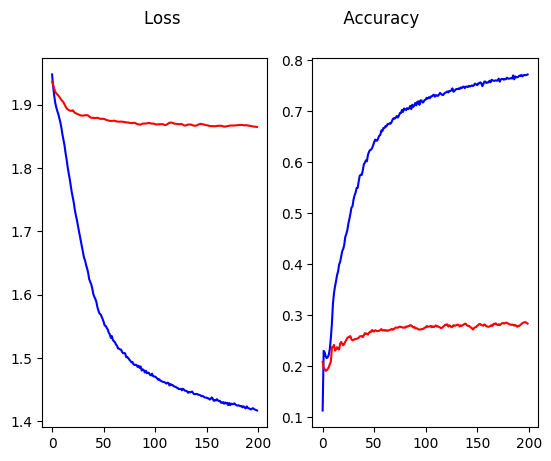

In [233]:
model_fcnn = FCNN(num_features=num_features, hidden_channels=64, num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model_fcnn.to(device)
graph_train_torch = graph_train_torch.to(device)
graph_test_torch = graph_test_torch.to(device)
list_loss_train, list_loss_test, list_train_acc, list_test_acc = train(
    model_fcnn,
    graph_train_torch,
    graph_test_torch,
    200
)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Loss                               Accuracy')
ax1.plot(list_loss_train, color='blue')
ax1.plot(list_loss_test, color='red')
ax2.plot(list_train_acc, color='blue')
ax2.plot(list_test_acc, color='red')

# Experience 2 : GCN

In [234]:
@track_emissions()
def train(model, graph_train, graph_test, epoches):
    learning_rate = 0.001
    decay = 1e-5
    optimizer = torch.optim.Adam(model.parameters(),
                                     lr=learning_rate,
                                     weight_decay=decay)
    criterion = torch.nn.CrossEntropyLoss()
    
    list_loss_train = []
    list_loss_test = []
    list_train_acc = []
    list_test_acc = []
    for epoch in range(epoches):
        model.train()
        optimizer.zero_grad()
        # Forward
        logits_train = model(graph_train.features, graph_train.edge_index)
        # Compute loss
        loss_train = criterion(logits_train, graph_train.labels) 
        list_loss_train.append(loss_train.item())
        # Backward
        loss_train.backward()
        optimizer.step()
        
        train_acc = (torch.argmax(logits_train, dim=1) == torch.argmax(graph_train.labels, dim=1)).float().mean()
        list_train_acc.append(train_acc)
        
        
        if epoch % 1 == 0:
            with torch.no_grad():
                model.eval()
                logits_test = model(graph_test.features, graph_test.edge_index)
                loss_test = criterion(logits_test, graph_test.labels)
                list_loss_test.append(loss_test.item())
                test_acc = (torch.argmax(logits_test, dim=1) == torch.argmax(graph_test.labels, dim=1)).float().mean()
                list_test_acc.append(test_acc)
                print('Epoch %d | Loss Train : %.4f | Train Accuracy : %.4f | Loss Test: %.4f | Test Accuracy: %.4f' % (epoch, loss_train.item(), train_acc, loss_test.item(), test_acc))
                
    return list_loss_train, list_loss_test, list_train_acc, list_test_acc

In [235]:
class GCN_1(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN_1, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.out = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # Message Passing Layer
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Output layer + softmax
        x = self.out(x)
        x = F.softmax(x, dim=1)
        return x

[codecarbon INFO @ 17:04:16] [setup] RAM Tracking...
[codecarbon INFO @ 17:04:16] [setup] GPU Tracking...
[codecarbon INFO @ 17:04:16] No GPU found.
[codecarbon INFO @ 17:04:16] [setup] CPU Tracking...
[codecarbon WARNING @ 17:04:16] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 17:04:18] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon INFO @ 17:04:18] >>> Tracker's metadata:
[codecarbon INFO @ 17:04:18]   Platform system: Linux-6.5.0-25-generic-x86_64-with-glibc2.38
[codecarbon INFO @ 17:04:18]   Python version: 3.10.13
[codecarbon INFO @ 17:04:18]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 17:04:18]   Available RAM : 15.355 GB
[codecarbon INFO @ 17:04:18]   CPU count: 8
[codecarbon INFO @ 17:04:18]   CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon INFO @ 17:04:18]   GPU count: None
[codecarbon INFO @ 17:04:18]   GPU model: None


Epoch 0 | Loss Train : 1.9473 | Train Accuracy : 0.1262 | Loss Test: 1.9447 | Test Accuracy: 0.1602
Epoch 1 | Loss Train : 1.9392 | Train Accuracy : 0.1769 | Loss Test: 1.9424 | Test Accuracy: 0.1832
Epoch 2 | Loss Train : 1.9303 | Train Accuracy : 0.2350 | Loss Test: 1.9400 | Test Accuracy: 0.2354
Epoch 3 | Loss Train : 1.9234 | Train Accuracy : 0.2664 | Loss Test: 1.9374 | Test Accuracy: 0.2750
Epoch 4 | Loss Train : 1.9148 | Train Accuracy : 0.2969 | Loss Test: 1.9347 | Test Accuracy: 0.2804
Epoch 5 | Loss Train : 1.9069 | Train Accuracy : 0.3129 | Loss Test: 1.9317 | Test Accuracy: 0.2736
Epoch 6 | Loss Train : 1.8972 | Train Accuracy : 0.3250 | Loss Test: 1.9286 | Test Accuracy: 0.2700
Epoch 7 | Loss Train : 1.8871 | Train Accuracy : 0.3430 | Loss Test: 1.9254 | Test Accuracy: 0.2655
Epoch 8 | Loss Train : 1.8792 | Train Accuracy : 0.3501 | Loss Test: 1.9221 | Test Accuracy: 0.2633
Epoch 9 | Loss Train : 1.8686 | Train Accuracy : 0.3548 | Loss Test: 1.9186 | Test Accuracy: 0.2687


[codecarbon INFO @ 17:04:24] 
Graceful stopping: collecting and writing information.
Please wait a few seconds...
[codecarbon INFO @ 17:04:24] Energy consumed for RAM : 0.000005 kWh. RAM Power : 5.7583093643188485 W
[codecarbon INFO @ 17:04:24] Energy consumed for all CPUs : 0.000013 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 17:04:24] 0.000018 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:04:24] Done!



Epoch 191 | Loss Train : 1.2493 | Train Accuracy : 0.9413 | Loss Test: 1.6060 | Test Accuracy: 0.6854
Epoch 192 | Loss Train : 1.2433 | Train Accuracy : 0.9475 | Loss Test: 1.6065 | Test Accuracy: 0.6859
Epoch 193 | Loss Train : 1.2456 | Train Accuracy : 0.9463 | Loss Test: 1.6065 | Test Accuracy: 0.6868
Epoch 194 | Loss Train : 1.2444 | Train Accuracy : 0.9464 | Loss Test: 1.6059 | Test Accuracy: 0.6850
Epoch 195 | Loss Train : 1.2463 | Train Accuracy : 0.9430 | Loss Test: 1.6056 | Test Accuracy: 0.6845
Epoch 196 | Loss Train : 1.2446 | Train Accuracy : 0.9470 | Loss Test: 1.6053 | Test Accuracy: 0.6836
Epoch 197 | Loss Train : 1.2442 | Train Accuracy : 0.9450 | Loss Test: 1.6048 | Test Accuracy: 0.6859
Epoch 198 | Loss Train : 1.2435 | Train Accuracy : 0.9473 | Loss Test: 1.6037 | Test Accuracy: 0.6863
Epoch 199 | Loss Train : 1.2465 | Train Accuracy : 0.9426 | Loss Test: 1.6028 | Test Accuracy: 0.6872


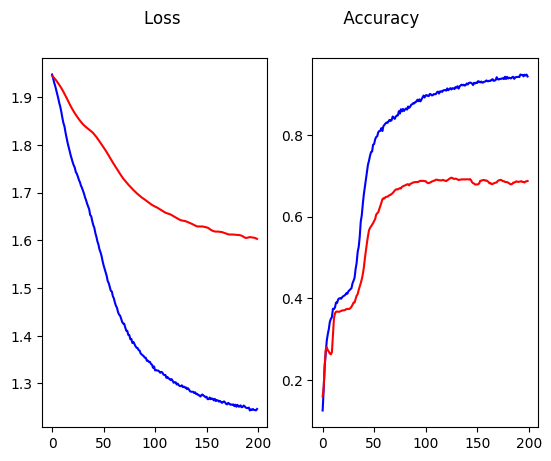

In [236]:
model_gcn1 = GCN_1(hidden_channels=64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gcn1 = model_gcn1.to(device)
graph_train_torch = graph_train_torch.to(device)
graph_test_torch = graph_test_torch.to(device)
list_loss_train, list_loss_test, list_train_acc, list_test_acc = train(
    model_gcn1,
    graph_train_torch,
    graph_test_torch,
    200
)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Loss                               Accuracy')
ax1.plot(list_loss_train, color='blue')
ax1.plot(list_loss_test, color='red')
ax2.plot(list_train_acc, color='blue')
ax2.plot(list_test_acc, color='red')

In [249]:
class GCN_2(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN_2, self).__init__()

        # Initialize the layers
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.out = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # First Message Passing Layer
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        
        # # Third Message Passing Layer
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Output layer + softmax
        x = self.out(x)
        x = F.softmax(x, dim=1)
        return x

In [250]:
model_gcn2 = GCN_2(hidden_channels=256)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gcn2 = model_gcn2.to(device)
graph_train_torch = graph_train_torch.to(device)
graph_test_torch = graph_test_torch.to(device)
list_loss_train, list_loss_test, list_train_acc, list_test_acc = train(
    model_gcn2,
    graph_train_torch,
    graph_test_torch,
    1000
)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Loss                               Accuracy')
ax1.plot(list_loss_train, color='blue')
ax1.plot(list_loss_test, color='red')
ax2.plot(list_train_acc, color='blue')
ax2.plot(list_test_acc, color='red')

[codecarbon INFO @ 17:29:38] [setup] RAM Tracking...
[codecarbon INFO @ 17:29:38] [setup] GPU Tracking...
[codecarbon INFO @ 17:29:38] No GPU found.
[codecarbon INFO @ 17:29:38] [setup] CPU Tracking...
[codecarbon WARNING @ 17:29:38] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 17:29:39] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon INFO @ 17:29:39] >>> Tracker's metadata:
[codecarbon INFO @ 17:29:39]   Platform system: Linux-6.5.0-25-generic-x86_64-with-glibc2.38
[codecarbon INFO @ 17:29:39]   Python version: 3.10.13
[codecarbon INFO @ 17:29:39]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 17:29:39]   Available RAM : 15.355 GB
[codecarbon INFO @ 17:29:39]   CPU count: 8
[codecarbon INFO @ 17:29:39]   CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon INFO @ 17:29:39]   GPU count: None
[codecarbon INFO @ 17:29:39]   GPU model: None


Epoch 0 | Loss Train : 1.9447 | Train Accuracy : 0.1680 | Loss Test: 1.9419 | Test Accuracy: 0.1890
Epoch 1 | Loss Train : 1.9358 | Train Accuracy : 0.2362 | Loss Test: 1.9385 | Test Accuracy: 0.1899
Epoch 2 | Loss Train : 1.9278 | Train Accuracy : 0.2199 | Loss Test: 1.9342 | Test Accuracy: 0.1899
Epoch 3 | Loss Train : 1.9200 | Train Accuracy : 0.2263 | Loss Test: 1.9290 | Test Accuracy: 0.1899
Epoch 4 | Loss Train : 1.9071 | Train Accuracy : 0.2146 | Loss Test: 1.9227 | Test Accuracy: 0.1899
Epoch 5 | Loss Train : 1.8948 | Train Accuracy : 0.2141 | Loss Test: 1.9163 | Test Accuracy: 0.1899
Epoch 6 | Loss Train : 1.8889 | Train Accuracy : 0.2159 | Loss Test: 1.9102 | Test Accuracy: 0.1899
Epoch 7 | Loss Train : 1.8790 | Train Accuracy : 0.2192 | Loss Test: 1.9037 | Test Accuracy: 0.1935
Epoch 8 | Loss Train : 1.8623 | Train Accuracy : 0.2597 | Loss Test: 1.8966 | Test Accuracy: 0.2988
Epoch 9 | Loss Train : 1.8394 | Train Accuracy : 0.3506 | Loss Test: 1.8887 | Test Accuracy: 0.3564


[codecarbon INFO @ 17:29:57] Energy consumed for RAM : 0.000024 kWh. RAM Power : 5.7583093643188485 W
[codecarbon INFO @ 17:29:57] Energy consumed for all CPUs : 0.000058 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 17:29:57] 0.000082 kWh of electricity used since the beginning.


Epoch 110 | Loss Train : 1.2156 | Train Accuracy : 0.9535 | Loss Test: 1.4602 | Test Accuracy: 0.7304
Epoch 111 | Loss Train : 1.2133 | Train Accuracy : 0.9564 | Loss Test: 1.4619 | Test Accuracy: 0.7309
Epoch 112 | Loss Train : 1.2108 | Train Accuracy : 0.9597 | Loss Test: 1.4602 | Test Accuracy: 0.7304
Epoch 113 | Loss Train : 1.2102 | Train Accuracy : 0.9597 | Loss Test: 1.4683 | Test Accuracy: 0.7160
Epoch 114 | Loss Train : 1.2116 | Train Accuracy : 0.9568 | Loss Test: 1.4655 | Test Accuracy: 0.7196
Epoch 115 | Loss Train : 1.2110 | Train Accuracy : 0.9586 | Loss Test: 1.4431 | Test Accuracy: 0.7475
Epoch 116 | Loss Train : 1.2085 | Train Accuracy : 0.9611 | Loss Test: 1.4374 | Test Accuracy: 0.7588
Epoch 117 | Loss Train : 1.2107 | Train Accuracy : 0.9595 | Loss Test: 1.4371 | Test Accuracy: 0.7579
Epoch 118 | Loss Train : 1.2078 | Train Accuracy : 0.9617 | Loss Test: 1.4487 | Test Accuracy: 0.7385
Epoch 119 | Loss Train : 1.2083 | Train Accuracy : 0.9602 | Loss Test: 1.4589 | Te

[codecarbon INFO @ 17:30:12] Energy consumed for RAM : 0.000048 kWh. RAM Power : 5.7583093643188485 W
[codecarbon INFO @ 17:30:12] Energy consumed for all CPUs : 0.000117 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 17:30:12] 0.000165 kWh of electricity used since the beginning.


Epoch 210 | Loss Train : 1.1827 | Train Accuracy : 0.9855 | Loss Test: 1.4841 | Test Accuracy: 0.7093
Epoch 211 | Loss Train : 1.1850 | Train Accuracy : 0.9844 | Loss Test: 1.4747 | Test Accuracy: 0.7187
Epoch 212 | Loss Train : 1.1812 | Train Accuracy : 0.9871 | Loss Test: 1.4693 | Test Accuracy: 0.7237
Epoch 213 | Loss Train : 1.1809 | Train Accuracy : 0.9875 | Loss Test: 1.4665 | Test Accuracy: 0.7295
Epoch 214 | Loss Train : 1.1803 | Train Accuracy : 0.9871 | Loss Test: 1.4638 | Test Accuracy: 0.7367
Epoch 215 | Loss Train : 1.1806 | Train Accuracy : 0.9882 | Loss Test: 1.4687 | Test Accuracy: 0.7349
Epoch 216 | Loss Train : 1.1845 | Train Accuracy : 0.9844 | Loss Test: 1.4845 | Test Accuracy: 0.7201
Epoch 217 | Loss Train : 1.1792 | Train Accuracy : 0.9896 | Loss Test: 1.5073 | Test Accuracy: 0.6908
Epoch 218 | Loss Train : 1.1824 | Train Accuracy : 0.9875 | Loss Test: 1.5078 | Test Accuracy: 0.6899
Epoch 219 | Loss Train : 1.1794 | Train Accuracy : 0.9898 | Loss Test: 1.4908 | Te

[codecarbon INFO @ 17:30:27] Energy consumed for RAM : 0.000072 kWh. RAM Power : 5.7583093643188485 W
[codecarbon INFO @ 17:30:27] Energy consumed for all CPUs : 0.000175 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 17:30:27] 0.000247 kWh of electricity used since the beginning.


Epoch 308 | Loss Train : 1.1755 | Train Accuracy : 0.9916 | Loss Test: 1.4473 | Test Accuracy: 0.7475
Epoch 309 | Loss Train : 1.1769 | Train Accuracy : 0.9904 | Loss Test: 1.4567 | Test Accuracy: 0.7372
Epoch 310 | Loss Train : 1.1767 | Train Accuracy : 0.9895 | Loss Test: 1.4644 | Test Accuracy: 0.7340
Epoch 311 | Loss Train : 1.1788 | Train Accuracy : 0.9884 | Loss Test: 1.4643 | Test Accuracy: 0.7228
Epoch 312 | Loss Train : 1.1760 | Train Accuracy : 0.9902 | Loss Test: 1.4678 | Test Accuracy: 0.7241
Epoch 313 | Loss Train : 1.1765 | Train Accuracy : 0.9907 | Loss Test: 1.4727 | Test Accuracy: 0.7129
Epoch 314 | Loss Train : 1.1787 | Train Accuracy : 0.9900 | Loss Test: 1.4705 | Test Accuracy: 0.7156
Epoch 315 | Loss Train : 1.1778 | Train Accuracy : 0.9896 | Loss Test: 1.4648 | Test Accuracy: 0.7295
Epoch 316 | Loss Train : 1.1774 | Train Accuracy : 0.9896 | Loss Test: 1.4628 | Test Accuracy: 0.7246
Epoch 317 | Loss Train : 1.1775 | Train Accuracy : 0.9886 | Loss Test: 1.4577 | Te

[codecarbon INFO @ 17:30:42] Energy consumed for RAM : 0.000096 kWh. RAM Power : 5.7583093643188485 W
[codecarbon INFO @ 17:30:42] Energy consumed for all CPUs : 0.000233 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 17:30:42] 0.000329 kWh of electricity used since the beginning.


Epoch 406 | Loss Train : 1.1722 | Train Accuracy : 0.9940 | Loss Test: 1.4948 | Test Accuracy: 0.6832
Epoch 407 | Loss Train : 1.1722 | Train Accuracy : 0.9938 | Loss Test: 1.4934 | Test Accuracy: 0.6850
Epoch 408 | Loss Train : 1.1741 | Train Accuracy : 0.9920 | Loss Test: 1.4850 | Test Accuracy: 0.6967
Epoch 409 | Loss Train : 1.1730 | Train Accuracy : 0.9933 | Loss Test: 1.4781 | Test Accuracy: 0.7075
Epoch 410 | Loss Train : 1.1732 | Train Accuracy : 0.9927 | Loss Test: 1.4797 | Test Accuracy: 0.7088
Epoch 411 | Loss Train : 1.1729 | Train Accuracy : 0.9935 | Loss Test: 1.4967 | Test Accuracy: 0.6899
Epoch 412 | Loss Train : 1.1726 | Train Accuracy : 0.9944 | Loss Test: 1.5208 | Test Accuracy: 0.6562
Epoch 413 | Loss Train : 1.1730 | Train Accuracy : 0.9936 | Loss Test: 1.5381 | Test Accuracy: 0.6116
Epoch 414 | Loss Train : 1.1745 | Train Accuracy : 0.9927 | Loss Test: 1.5440 | Test Accuracy: 0.6116
Epoch 415 | Loss Train : 1.1729 | Train Accuracy : 0.9940 | Loss Test: 1.5459 | Te

[codecarbon WARNING @ 17:31:49] Background scheduler didn't run for a long period (66s), results might be inaccurate
[codecarbon INFO @ 17:31:49] Energy consumed for RAM : 0.000203 kWh. RAM Power : 5.7583093643188485 W
[codecarbon INFO @ 17:31:49] Energy consumed for all CPUs : 0.000493 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 17:31:49] 0.000696 kWh of electricity used since the beginning.


Epoch 449 | Loss Train : 1.1724 | Train Accuracy : 0.9942 | Loss Test: 1.5227 | Test Accuracy: 0.6355
Epoch 450 | Loss Train : 1.1729 | Train Accuracy : 0.9946 | Loss Test: 1.5069 | Test Accuracy: 0.6683
Epoch 451 | Loss Train : 1.1727 | Train Accuracy : 0.9933 | Loss Test: 1.4864 | Test Accuracy: 0.7007
Epoch 452 | Loss Train : 1.1723 | Train Accuracy : 0.9936 | Loss Test: 1.4809 | Test Accuracy: 0.7048
Epoch 453 | Loss Train : 1.1722 | Train Accuracy : 0.9935 | Loss Test: 1.4838 | Test Accuracy: 0.6967
Epoch 454 | Loss Train : 1.1739 | Train Accuracy : 0.9920 | Loss Test: 1.4862 | Test Accuracy: 0.6953
Epoch 455 | Loss Train : 1.1730 | Train Accuracy : 0.9933 | Loss Test: 1.4932 | Test Accuracy: 0.6940
Epoch 456 | Loss Train : 1.1724 | Train Accuracy : 0.9944 | Loss Test: 1.5047 | Test Accuracy: 0.6751
Epoch 457 | Loss Train : 1.1730 | Train Accuracy : 0.9933 | Loss Test: 1.5066 | Test Accuracy: 0.6701
Epoch 458 | Loss Train : 1.1729 | Train Accuracy : 0.9933 | Loss Test: 1.5207 | Te

[codecarbon INFO @ 17:32:04] Energy consumed for RAM : 0.000227 kWh. RAM Power : 5.7583093643188485 W
[codecarbon INFO @ 17:32:04] Energy consumed for all CPUs : 0.000551 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 17:32:04] 0.000778 kWh of electricity used since the beginning.


Epoch 546 | Loss Train : 1.1719 | Train Accuracy : 0.9944 | Loss Test: 1.5281 | Test Accuracy: 0.6197
Epoch 547 | Loss Train : 1.1718 | Train Accuracy : 0.9946 | Loss Test: 1.5349 | Test Accuracy: 0.6094
Epoch 548 | Loss Train : 1.1715 | Train Accuracy : 0.9947 | Loss Test: 1.5382 | Test Accuracy: 0.6085
Epoch 549 | Loss Train : 1.1718 | Train Accuracy : 0.9942 | Loss Test: 1.5405 | Test Accuracy: 0.6076
Epoch 550 | Loss Train : 1.1717 | Train Accuracy : 0.9942 | Loss Test: 1.5371 | Test Accuracy: 0.6080
Epoch 551 | Loss Train : 1.1734 | Train Accuracy : 0.9927 | Loss Test: 1.5163 | Test Accuracy: 0.6413
Epoch 552 | Loss Train : 1.1721 | Train Accuracy : 0.9940 | Loss Test: 1.4897 | Test Accuracy: 0.6877
Epoch 553 | Loss Train : 1.1718 | Train Accuracy : 0.9942 | Loss Test: 1.4775 | Test Accuracy: 0.7030
Epoch 554 | Loss Train : 1.1725 | Train Accuracy : 0.9942 | Loss Test: 1.4690 | Test Accuracy: 0.7070
Epoch 555 | Loss Train : 1.1721 | Train Accuracy : 0.9942 | Loss Test: 1.4779 | Te

[codecarbon WARNING @ 14:02:47] Background scheduler didn't run for a long period (73842s), results might be inaccurate
[codecarbon INFO @ 14:02:47] Energy consumed for RAM : 0.118340 kWh. RAM Power : 5.7583093643188485 W
[codecarbon INFO @ 14:02:47] Energy consumed for all CPUs : 0.287717 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 14:02:47] 0.406057 kWh of electricity used since the beginning.


Epoch 625 | Loss Train : 1.1712 | Train Accuracy : 0.9949 | Loss Test: 1.5199 | Test Accuracy: 0.6328
Epoch 626 | Loss Train : 1.1710 | Train Accuracy : 0.9951 | Loss Test: 1.5172 | Test Accuracy: 0.6386
Epoch 627 | Loss Train : 1.1714 | Train Accuracy : 0.9949 | Loss Test: 1.5211 | Test Accuracy: 0.6287
Epoch 628 | Loss Train : 1.1719 | Train Accuracy : 0.9940 | Loss Test: 1.5085 | Test Accuracy: 0.6638
Epoch 629 | Loss Train : 1.1715 | Train Accuracy : 0.9946 | Loss Test: 1.4961 | Test Accuracy: 0.6800
Epoch 630 | Loss Train : 1.1720 | Train Accuracy : 0.9946 | Loss Test: 1.4909 | Test Accuracy: 0.6926
Epoch 631 | Loss Train : 1.1731 | Train Accuracy : 0.9947 | Loss Test: 1.4946 | Test Accuracy: 0.6872
Epoch 632 | Loss Train : 1.1722 | Train Accuracy : 0.9946 | Loss Test: 1.5150 | Test Accuracy: 0.6521
Epoch 633 | Loss Train : 1.1712 | Train Accuracy : 0.9949 | Loss Test: 1.5314 | Test Accuracy: 0.6094
Epoch 634 | Loss Train : 1.1712 | Train Accuracy : 0.9949 | Loss Test: 1.5428 | Te

[codecarbon INFO @ 14:02:58] 
Graceful stopping: collecting and writing information.
Please wait a few seconds...
[codecarbon INFO @ 14:02:58] Energy consumed for RAM : 0.118359 kWh. RAM Power : 5.7583093643188485 W
[codecarbon INFO @ 14:02:58] Energy consumed for all CPUs : 0.287762 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 14:02:58] 0.406120 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:02:58] Done!



KeyboardInterrupt: 

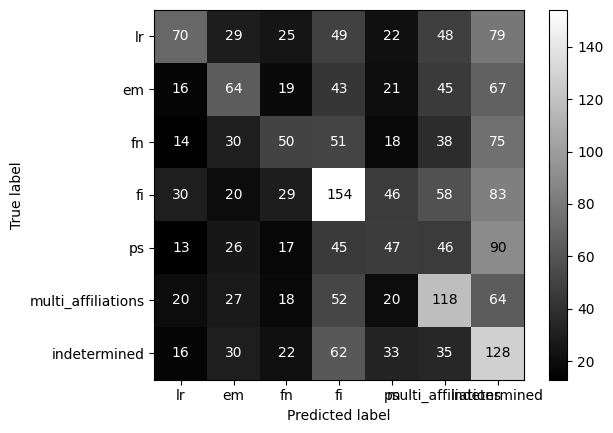

In [248]:
with torch.no_grad():
    model_fcnn.eval()
    y_true = torch.argmax(graph_test_torch.labels, dim=1).cpu().numpy()
    y_pred = torch.argmax(model_fcnn(graph_test_torch.features), dim=1).cpu().numpy()
    mat = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=mat, display_labels=['lr','em','fn','fi','ps','multi_affiliations','indetermined']).plot(cmap='gray')

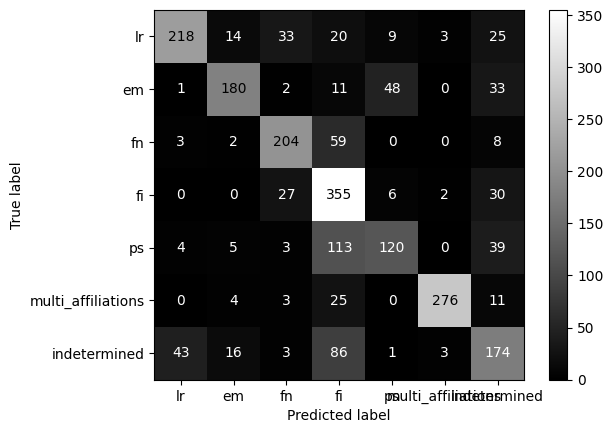

In [240]:
with torch.no_grad():
    model_gcn1.eval()
    y_true = torch.argmax(graph_test_torch.labels, dim=1).cpu().numpy()
    y_pred = torch.argmax(model_gcn1(graph_test_torch.features, graph_test_torch.edge_index), dim=1).cpu().numpy()
    mat = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=mat, display_labels=['lr','em','fn','fi','ps','multi_affiliations','indetermined']).plot(cmap='gray')                                                                               

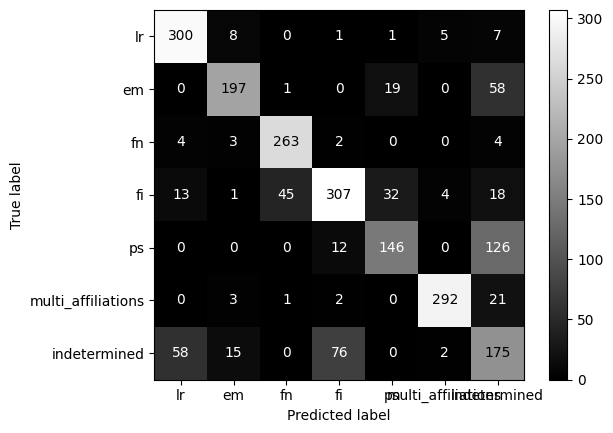

In [241]:
with torch.no_grad():
    model_gcn2.eval()
    y_true = torch.argmax(graph_test_torch.labels, dim=1).cpu().numpy()
    y_pred = torch.argmax(model_gcn2(graph_test_torch.features, graph_test_torch.edge_index), dim=1).cpu().numpy()
    mat = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=mat, display_labels=['lr','em','fn','fi','ps','multi_affiliations','indetermined']).plot(cmap='gray')

In [242]:
from codecarbon import track_emissions
@track_emissions()
def track_gcn():
    for i in range(1_000):
        with torch.no_grad():
            model_gcn2.eval()
            out = model_gcn2(graph_test_torch.features, graph_test_torch.edge_index)

In [243]:
track_gcn()

[codecarbon INFO @ 17:04:38] [setup] RAM Tracking...
[codecarbon INFO @ 17:04:38] [setup] GPU Tracking...
[codecarbon INFO @ 17:04:38] No GPU found.
[codecarbon INFO @ 17:04:38] [setup] CPU Tracking...
[codecarbon WARNING @ 17:04:38] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 17:04:39] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon INFO @ 17:04:39] >>> Tracker's metadata:
[codecarbon INFO @ 17:04:39]   Platform system: Linux-6.5.0-25-generic-x86_64-with-glibc2.38
[codecarbon INFO @ 17:04:39]   Python version: 3.10.13
[codecarbon INFO @ 17:04:39]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 17:04:39]   Available RAM : 15.355 GB
[codecarbon INFO @ 17:04:39]   CPU count: 8
[codecarbon INFO @ 17:04:39]   CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon INFO @ 17:04:39]   GPU count: None
[codecarbon INFO @ 17:04:39]   GPU model: None
[codecarbon INFO @ 17:04:47] 
Graceful stoppi

[0.7560756206512451, 0.09360936284065247, 0.062106210738420486, 0.06345634907484055, 0.015301530249416828, 0.007650765124708414, 0.0018001800635829568]


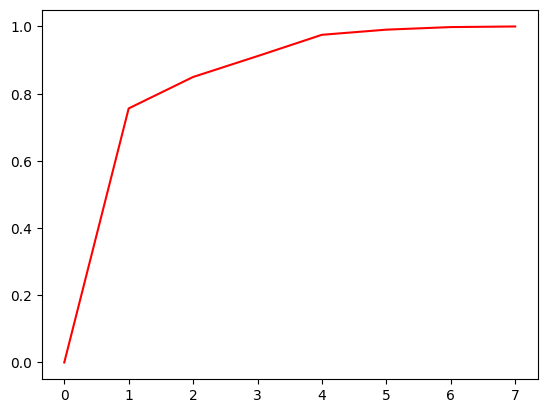

In [244]:
with torch.no_grad():
    model_gcn2.eval()
    logits_test = model_gcn2(graph_test_torch.features, graph_test_torch.edge_index)
    logits_test = torch.argsort(logits_test, dim=1)
    true_labels = torch.argmax(graph_test_torch.labels, dim=1)
    list_test_acc = []
    for i in range(7):
        list_test_acc.append(
            float((logits_test[:,i] == true_labels).float().mean())
        )
    list_test_acc = list_test_acc[::-1]
    print(list_test_acc)
    # plt.plot(list_test_acc, color='blue')
    list_test_acc_cumul = [0.0] + [sum(list_test_acc[:i]) for i in range(1,8)]
    plt.plot(list_test_acc_cumul, color='red')
